# Imports etc.

In [1]:
import json
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)

In [2]:
# data_dir = 'C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/mTurk1'
data_dir = 'C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPP'
plot_dir = data_dir + 'figures'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Get data

## mTurk

In [3]:
interesting_cols = [
    'rt', 'trial_type', 'phase', 'block', 'trial', 'trial_', 'subtrial', 'points', #'key_press',
    'action_id', 'middle_item_name', 'goal_star_name', 'goal_star', 'correct', 'unlocked_star', #'middle_item',
    'unlocked_star_name', 'timeout', #'action_name',
]

In [4]:
def raw_data_row2pd(data_row):
    
    return pd.DataFrame(json.loads(data_row['trialdata']))

# # Use
# pd.concat([raw_data_row2pd(task_data_raw[i[0]]) for i in trial_data_rows])

In [5]:
def raw_data2rules_data(rule_row):
    
    # Get rules data
    rule_cols = ['middleRules', 'lowTransferRules', 'highTransferRules', 'highRules', 'taskVer', 'phaseNum']
    rules_dat = pd.DataFrame({rule_col: rule_row['trialdata'][rule_col] for rule_col in rule_cols})
    
    # Clean it up
    rules_dat = rules_dat.reset_index().rename(columns={'index': 'goal_id'})
    rules_dat['taskVer'] = rules_dat['taskVer'].replace({'A': 'high', 'B': 'low'})
    rules_dat = rules_dat.rename(columns={'middleRules': 'lowRules', 'taskVer': 'phase'})
    
    return rules_dat

# # Use
# pd.concat([raw_data2rules_data(rule_row) for rule_row in rule_rows])
# # raw_data2rules_data(rule_rows[0])

In [6]:
def get_all_mTurk_data(data_dir):
    
    # Read in and process data
    file_names = os.listdir(data_dir)
    all_data_raw = pd.DataFrame()
    all_rules = pd.DataFrame()

    for sid, file_name in enumerate(file_names):

        # Read in raw data
        with open(os.path.join(data_dir, file_name)) as f:
            raw_data = json.load(f)

        # Get actual task data
        subj_data_raw = raw_data['data']

        trial_data_len = [len(subj_data_raw[i]['trialdata']) for i in range(len(subj_data_raw))]
        trial_data_rows = np.argwhere(np.array(trial_data_len) > 10000).flatten()  # rows with less than 10000 entries contain other stuff (e.g., rules)

        subj_data = pd.concat([raw_data_row2pd(subj_data_raw[i]) for i in trial_data_rows])

        # Add basic info
        subj_data['sid'] = sid
        subj_data['workerId'] = raw_data['workerId']
        subj_data['counterbalance'] = raw_data['counterbalance']
        subj_data['start_dateTime'] = raw_data['data'][0]['dateTime']
        subj_data['end_dateTime'] = raw_data['data'][-1]['dateTime']

        # Combine all subjects
        all_data_raw = pd.concat([all_data_raw, subj_data])

        # Get rule data
        rule_row_idx = np.argwhere(np.array(trial_data_len) == 21).flatten()  # trials with length 21 contain the rules
        rule_rows = [raw_data['data'][i] for i in rule_row_idx]

        subj_rules = pd.concat([raw_data2rules_data(rule_row) for rule_row in rule_rows])
        subj_rules['sid'] = sid

        all_rules = pd.concat([all_rules, subj_rules])

    return all_data_raw, all_rules

# # Use
# get_all_mTurk_data(data_dir)

In [7]:
def get_all_RPP_data(data_dir):

    file_names = os.listdir(data_dir)

    all_data_raw = pd.DataFrame()
    for sid, file_name in enumerate(file_names):

        print("Reading in {}".format(file_name))

        # Get raw json
        subj_dat = pd.read_json(os.path.join(data_dir, file_name))
        subj_dat['sid'] = sid
        subj_dat['start_dateTime'] = subj_dat.time_elapsed[subj_dat.time_elapsed.index[0]]
        subj_dat['end_dateTime'] = subj_dat.time_elapsed[subj_dat.time_elapsed.index[-1]]

        # Combine
        all_data_raw = pd.concat([all_data_raw, subj_dat])

    return all_data_raw
    
# # Use
# get_all_RPP_data(data_dir)

In [8]:
def get_rule_data_rpp(all_data_raw):
    
    # Get raw rules data
    rule_rows = all_data_raw.highTransferRules.apply(lambda x : type(x) == dict)
    rule_cols = ['permKeys', 'permKeysOrder', 'permMiddleItems', 'permStars', 'middleRules', 'highRules',
                 'lowTransferRules', 'highTransferRules', 'taskVer', 'phaseNum', 'keys', 'letters',
                 'learnGoals', 'transferGoals']
    rule_data = all_data_raw.loc[rule_rows, ['sid'] + rule_cols].reset_index(drop=True)
    rule_data['taskVer'] = pd.Categorical(rule_data['taskVer']).rename_categories({'A': 'high', 'B': 'low'})
    rule_data = rule_data.rename(columns={'middleRules': 'lowRules', 'taskVer': 'phase'})
    
    return rule_data

# # Use
# get_rule_data_rpp(all_data_raw)

In [9]:
def get_one_rule(rule_data, rule_col):
    
    r = rule_data[rule_col].apply(pd.Series)  # Split each cell (containing a dict) into several cells
    r[['sid', 'phase']] = rule_data[['sid', 'phase']]  # Get sid and phase for each row
    r = r.melt(id_vars=['sid', 'phase'], var_name='goal_id', value_name=rule_col)  # Melt
    
    return r

# # Use
# get_one_rule(rule_data, 'lowRules')

In [10]:
def clean_rule_data_rpp(rule_data_raw):
    
    # Select rule columns
    rule_cols_sub = ['sid', 'lowRules', 'highRules', 'lowTransferRules', 'highTransferRules', 'phase']
    rule_data_raw = rule_data_raw[rule_cols_sub]

    # Replace hypothetical, never-used transfer rules with the actual experimental rule during that phase
    rule_data_raw.loc[rule_data_raw.phase == 'low', 'highTransferRules'] = np.nan  # rule_data_raw.loc[rule_data_raw.phase == 'low', 'highRules']
    rule_data_raw.loc[rule_data_raw.phase == 'high', 'lowTransferRules'] = np.nan  # rule_data_raw.loc[rule_data_raw.phase == 'high', 'lowRules']
    
    # Melt to split the dictionary across columns
    rule_cols = ['lowRules', 'highRules', 'lowTransferRules', 'highTransferRules']
    rule_data = get_one_rule(rule_data_raw, rule_cols[0])

    for rule_col in rule_cols[1:]:

        r = rule_data_raw[rule_col].apply(pd.Series)  # Split each cell (containing a dict) into several cells
        r[['sid', 'phase']] = rule_data_raw[['sid', 'phase']]  # Get sid and phase for each row
        r = r.melt(id_vars=['sid', 'phase'], var_name='goal_id', value_name=rule_col)  # Melt

        rule_data = pd.merge(rule_data, r, on=['sid', 'phase', 'goal_id'])

    return rule_data

# # Use
# clean_rule_data_rpp(rule_data_raw)

In [11]:
def msec2min(msec):
    
    sec = msec / 1000
    minutes = sec / 60
    return minutes

# Example use
s19 = 1806710 - 145800
s67 = 1913718 - 56652
msec2min(s19), msec2min(s67)

(27.681833333333334, 30.9511)

In [12]:
def clean_all_data(all_data_raw):
    
    all_data = all_data_raw.loc[all_data_raw.trial_type.isin(['learning', 'transfer'])]  # remove instructions
    all_data = all_data.loc[all_data.subtrial.isin(range(4))]  # remove 5th (feedback) trial
    all_data['phase'] = all_data['phase'].replace({'A': 'high', 'B': 'low'})
    all_data['trial_'] = all_data['block'] * 25 + all_data['trial']  # get continuous trials over blocks
    all_data['duration'] = msec2min(all_data['end_dateTime'] - all_data['start_dateTime'])  # task duration
    acc_mask = all_data['subtrial'] == 3
    all_data.loc[acc_mask, 'acc'] = (all_data.loc[acc_mask, 'goal_star'] == all_data.loc[acc_mask, 'unlocked_star']).astype(int)  # acc of each trial (`correct` is only for successful star trials)
    all_data = all_data.reset_index(drop=True)
    
    return all_data

# # Use
# clean_all_data(all_data_raw)

In [13]:
if 'RPP' in data_dir:
    all_data_raw = get_all_RPP_data(data_dir)
    rule_data_raw = get_rule_data_rpp(all_data_raw)
    rule_data = clean_rule_data_rpp(rule_data_raw)
    
elif 'mTurk' in data_dir:
    all_data_raw, rule_data = get_all_mTurk_data(data_dir)
    
else:
    raise(ValueError, 'Must be RPP or mTurk.')
    
all_data = clean_all_data(all_data_raw)
rule_data

Reading in CHaRLy_subj11311_2020615_1_39.json
Reading in CHaRLy_subj19774_2020-6-15_12_6.json
Reading in CHaRLy_subj19888_2020-6-15_12_22.json
Reading in CHaRLy_subj31309_2020-6-15_10_16.json


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,sid,phase,goal_id,lowRules,highRules,lowTransferRules,highTransferRules
0,0,low,0,"[2, 3]","[3, 1]","[2, 3]",NaN
1,0,high,0,"[1, 2]","[1, 2]",NaN,"[1, 2]"
2,1,low,0,"[3, 0]","[1, 3]","[3, 1]",NaN
3,1,high,0,"[1, 2]","[1, 0]",NaN,"[2, 0]"
4,2,high,0,"[3, 0]","[1, 3]",NaN,"[0, 3]"
5,2,low,0,"[0, 1]","[3, 2]","[0, 1]",NaN
6,3,high,0,"[3, 0]","[2, 0]",NaN,"[2, 3]"
7,3,low,0,"[2, 3]","[1, 3]","[2, 3]",NaN
8,0,low,1,"[0, 1]","[1, 0]","[0, 1]",NaN
9,0,high,1,"[0, 1]","[3, 1]",NaN,"[3, 1]"


## Add hypothetical middle-level items and stars to all_data

In [14]:
def get_goal_rule(trial_rules, goal_id, rule_name):
    
    goal_rule = trial_rules.loc[trial_rules['goal_id'] == goal_id, rule_name]
    return goal_rule[goal_rule.index[0]]

# # Use
# get_goal_rule(trial_rules, goal_id, 'lowRules')

In [15]:
def actions2items(trial_rules, actions, low_rule_name):
    
    items = 4 * [np.nan]

    for goal_id in trial_rules.goal_id:
        goal_rule = get_goal_rule(trial_rules, goal_id, low_rule_name)
        
        for i, action_tuple in enumerate([np.array(actions[:2]), np.array(actions[2:])]):
            if np.all(action_tuple == goal_rule):
                items[2 * i + 1] = int(goal_id)

    return items
        
# # Use
# actions = [3, 0, 2, 3]
# actions = [3, 1, 2, 3]
# actions2items(trial_rules, actions, 'lowRules')

In [16]:
def items2stars(trial_rules, items, high_rule_name):

    for goal_id in trial_rules.goal_id:

        goal_rule = get_goal_rule(trial_rules, goal_id, high_rule_name)
        comp_items = np.array([items[1], items[3]])

        # Valid sequence of two items
        if np.all(goal_rule == comp_items):
            return 3 * [np.nan,] + [int(goal_id)]

    # No valid sequence of two items
    return 4 * [np.nan,]
        
# # Use
# items = [np.nan, 1, np.nan, 2]
# items2stars(trial_rules, items, high_rule_name)

In [17]:
# Add a column for each rule
for sid in set(all_data.sid):
    print(' sid: {}'.format(sid))
    
    for trial_type in set(all_data.trial_type):
        print('  trial_type: {}'.format(trial_type))
        
        for phase in set(all_data.phase):
            print('   phase: {}'.format(phase))

            # Get rules for this sid and this phase
            trial_rules = rule_data.loc[
                (rule_data.sid == sid) & (rule_data.phase == phase)
            ]
            
            if trial_rules.shape[0] > 0:

                for block in set(all_data.block):

                    for trial in set(all_data.trial):

                        all_data_mask = (all_data.sid == sid) & (all_data.phase == phase) & (
                            all_data.trial_type == trial_type) & (all_data.block == block) & (all_data.trial == trial)

                        # Get actions and items for this sid, this phase, this trial_type, this block, and this trial
                        trial_dat = all_data.loc[all_data_mask]
                        actions = trial_dat.action_id
                        items = list(trial_dat.middle_item_name)

                        if trial_dat.shape[0] == 4:  # Make sure we have 4 valid trials

                            for rule_name in [c for c in rule_data.columns if 'Rules' in c]:
                                if 'low' in rule_name:

                                    pred_middle_items = actions2items(trial_rules, actions, rule_name)
                                    all_data.loc[all_data_mask, 'middle_item_' + rule_name] = pred_middle_items

                                if 'high' in rule_name:

                                    pred_star = items2stars(trial_rules, items, rule_name)
                                    all_data.loc[all_data_mask, 'unlocked_star_' + rule_name] = pred_star

 sid: 0
  trial_type: learning
   phase: high
   phase: low
  trial_type: transfer
   phase: high
   phase: low
 sid: 1
  trial_type: learning
   phase: high
   phase: low
  trial_type: transfer
   phase: high
   phase: low
 sid: 2
  trial_type: learning
   phase: high
   phase: low
  trial_type: transfer
   phase: high
   phase: low
 sid: 3
  trial_type: learning
   phase: high
   phase: low
  trial_type: transfer
   phase: high
   phase: low


In [18]:
# Verifying that assigning theoretical items and stars was accurate
learn_data = all_data.loc[(all_data.trial_type == 'learning') & np.invert(np.isnan(all_data.middle_item_name))]
np.mean(learn_data.middle_item_name == learn_data.middle_item_lowRules)

cols = ['sid', 'phase', 'trial_type', 'trial_', 'trial', 'subtrial', 'block', 'middle_item_name', 'middle_item_lowRules', 'unlocked_star_name', 'unlocked_star_highRules']
learn_data.loc[learn_data.middle_item_name != learn_data.middle_item_lowRules, cols]

learn_data = all_data.loc[(all_data.trial_type == 'learning') & np.invert(np.isnan(all_data.unlocked_star_name))
                          & np.invert(all_data.unlocked_star_name == -1)
                         ]
np.mean(learn_data.unlocked_star_name == learn_data.unlocked_star_highRules)
learn_data.loc[learn_data.unlocked_star_name != learn_data.unlocked_star_highRules, cols]

,sid,phase,trial_type,trial_,trial,subtrial,block,middle_item_name,middle_item_lowRules,unlocked_star_name,unlocked_star_highRules


In [19]:
# Boolean indicator for when items / stars would have appeared for each set of rules (lowRules, lowTransferRules, highRules, highTransferRules)
all_data['bool_middle_item_lowRules'] = np.invert(np.isnan(all_data['middle_item_lowRules'])).astype(int)
all_data['bool_unlocked_star_highRules'] = np.invert(np.isnan(all_data['unlocked_star_highRules'])).astype(int)
all_data['bool_middle_item_lowTransferRules'] = np.invert(np.isnan(all_data['middle_item_lowTransferRules'])).astype(int)
all_data['bool_unlocked_star_highTransferRules'] = np.invert(np.isnan(all_data['unlocked_star_highTransferRules'])).astype(int)

In [20]:
# Add chance performer column to all_data
chance_performers = all_data.groupby(['sid', 'phase', 'trial_type']).aggregate('mean')['points'].reset_index()
chance_performers = chance_performers.groupby(['sid']).aggregate('count')['phase'].reset_index()
chance_performers = chance_performers.loc[chance_performers['phase'] == 1, 'sid']

all_data['chance_performer'] = all_data['sid'].isin(chance_performers)

In [21]:
interesting_cols += [
    'middle_item_lowTransferRules', 'middle_item_lowRules', 'bool_middle_item_lowRules',
    'unlocked_star_highTransferRules', 'unlocked_star_highRules', 'bool_unlocked_star_highRules',
    'chance_performer',
]

# Results

## Data overview

In [22]:
id_cols = ['sid', 'trial_type', 'phase']
all_data[interesting_cols + id_cols].groupby(id_cols[0]).mean()

,rt,block,trial,trial_,subtrial,points,action_id,middle_item_name,goal_star_name,goal_star,...,unlocked_star,unlocked_star_name,timeout,middle_item_lowTransferRules,middle_item_lowRules,bool_middle_item_lowRules,unlocked_star_highTransferRules,unlocked_star_highRules,bool_unlocked_star_highRules,chance_performer
sid,,,,,,,,,,,,,,,,,,,,,
0,237.790055,4.702980,12.006511,129.581017,1.498873,268.889056,1.483596,1.560853,1.896690,1.498495,...,0.406219,0.561685,1.0,1.242424,1.467514,0.354621,1.555556,1.411765,0.127724,False
1,269.484559,4.700175,11.999499,129.503886,1.498120,187.081975,1.612184,1.347396,1.298492,1.499497,...,0.130653,0.135678,1.0,1.383234,1.319228,0.337679,1.219895,1.624021,0.096014,False
2,321.878780,4.746962,12.162969,130.837031,1.469361,209.738246,1.489171,1.615385,1.099675,1.476706,...,0.070423,0.217768,1.0,1.754569,1.621302,0.401743,1.177340,1.493857,0.107501,False
3,292.278181,4.715840,12.039221,129.935223,1.491903,149.353998,1.504555,1.755814,1.505618,1.505618,...,-0.084780,-0.027579,1.0,1.655046,1.761098,0.313512,0.963636,1.503817,0.099443,False


In [23]:
all_data[interesting_cols].describe()

,rt,block,trial,trial_,subtrial,points,action_id,middle_item_name,goal_star_name,goal_star,correct,unlocked_star,unlocked_star_name,timeout,middle_item_lowTransferRules,middle_item_lowRules,bool_middle_item_lowRules,unlocked_star_highTransferRules,unlocked_star_highRules,bool_unlocked_star_highRules
count,15613.000000,15720.000000,15720.000000,15720.000000,15720.000000,15720.000000,15720.000000,5766.000000,3894.000000,3894.000000,1963.000000,3894.000000,3894.000000,107.0,1990.000000,5523.000000,15720.000000,665.000000,1693.000000,15720.000000
mean,279.570438,4.716094,12.050636,129.952990,1.489822,203.833333,1.522837,1.561221,1.456600,1.495378,0.854305,0.132768,0.223164,1.0,1.489447,1.539562,0.351336,1.294737,1.500886,0.107697
std,294.346180,3.197567,7.186649,80.267425,1.119956,138.228939,1.120962,1.169124,1.137612,0.923954,0.352890,1.323032,1.420111,0.0,1.236954,1.155127,0.477403,1.086771,0.995038,0.310007
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,119.875000,2.000000,6.000000,63.000000,0.000000,97.000000,1.000000,0.000000,0.000000,1.000000,1.000000,-1.000000,-1.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,187.785000,5.000000,12.000000,125.000000,1.000000,187.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000
75%,312.775000,7.000000,18.000000,187.000000,2.000000,304.000000,3.000000,3.000000,2.750000,2.000000,1.000000,1.000000,2.000000,1.0,3.000000,3.000000,1.000000,2.000000,2.000000,0.000000
max,2500.205000,11.000000,24.000000,299.000000,3.000000,535.000000,3.000000,3.000000,3.000000,3.000000,1.000000,3.000000,3.000000,1.0,3.000000,3.000000,1.000000,3.000000,3.000000,1.000000


In [24]:
all_data.loc[:30, interesting_cols]

,rt,trial_type,phase,block,trial,trial_,subtrial,points,action_id,middle_item_name,...,unlocked_star,unlocked_star_name,timeout,middle_item_lowTransferRules,middle_item_lowRules,bool_middle_item_lowRules,unlocked_star_highTransferRules,unlocked_star_highRules,bool_unlocked_star_highRules,chance_performer
0,1169.265,learning,low,0.0,0.0,0.0,0.0,2.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,False
1,223.445,learning,low,0.0,0.0,0.0,1.0,2.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,False
2,233.005,learning,low,0.0,0.0,0.0,2.0,2.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,False
3,183.930,learning,low,0.0,0.0,0.0,3.0,2.0,2.0,NaN,...,-1.0,-1.0,NaN,2.0,NaN,0,NaN,NaN,0,False
4,1006.985,learning,low,0.0,1.0,1.0,0.0,2.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,False
5,259.570,learning,low,0.0,1.0,1.0,1.0,2.0,1.0,NaN,...,NaN,NaN,NaN,3.0,NaN,0,NaN,NaN,0,False
6,212.045,learning,low,0.0,1.0,1.0,2.0,2.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,False
7,215.820,learning,low,0.0,1.0,1.0,3.0,2.0,2.0,NaN,...,-1.0,-1.0,NaN,2.0,NaN,0,NaN,NaN,0,False
8,331.455,learning,low,0.0,2.0,2.0,0.0,2.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,False
9,227.745,learning,low,0.0,2.0,2.0,1.0,2.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,False


## Raw button presses

## Task Duration

Durations: [28. 32. 43. 32.]


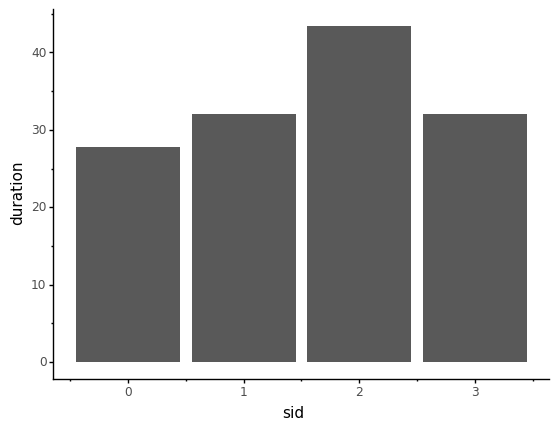

<ggplot: (-9223371914253798056)>

In [25]:
dur_dat = all_data.groupby(['sid']).aggregate('mean')['duration'].reset_index()
print("Durations: {}".format(dur_dat['duration'].values.round()))

g = (gg.ggplot(dur_dat, gg.aes('sid', 'duration'))
     + gg.geom_bar(stat='identity')
    )
g

## Raw button presses

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\0_RawKeyPresses.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


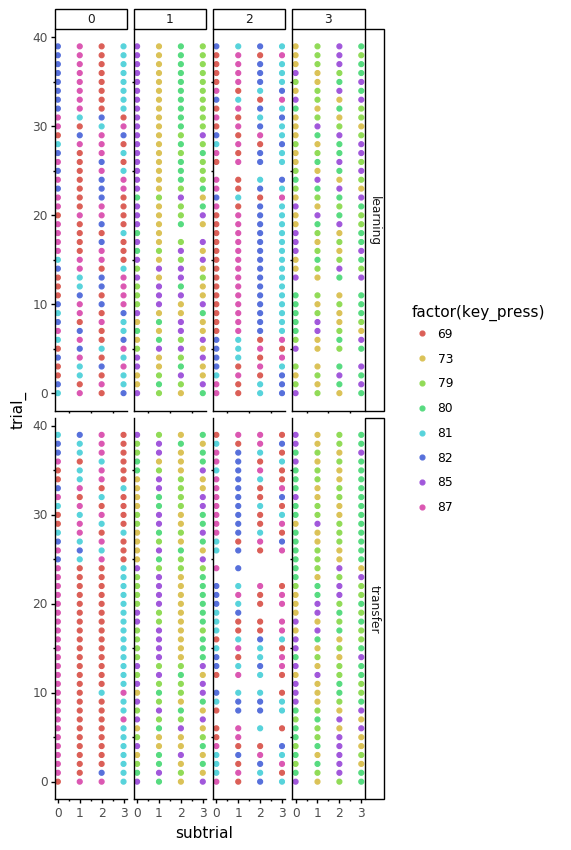

<ggplot: (122601065792)>


In [32]:
sub_dat = all_data.loc[
#     (all_data.trial_type == 'learning') & 
    (all_data.phase == 'high')
    & np.invert(np.isnan(all_data.key_press)) & (all_data.trial_ < 40)
]

gg.options.figure_size = (4, 10)
g = (gg.ggplot(sub_dat, gg.aes('subtrial', 'trial_', color='factor(key_press)'))
     + gg.geom_point()
     + gg.facet_grid('trial_type ~ sid', scales='free_x')
    )
g.save(os.path.join(plot_dir, '0_RawKeyPresses.png'))
print(g)
gg.options.figure_size = (6.4, 4.8)  # Reset default figure size

## Points won over time

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\0_PointsOverTrials_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\0_PointsOverTrials.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


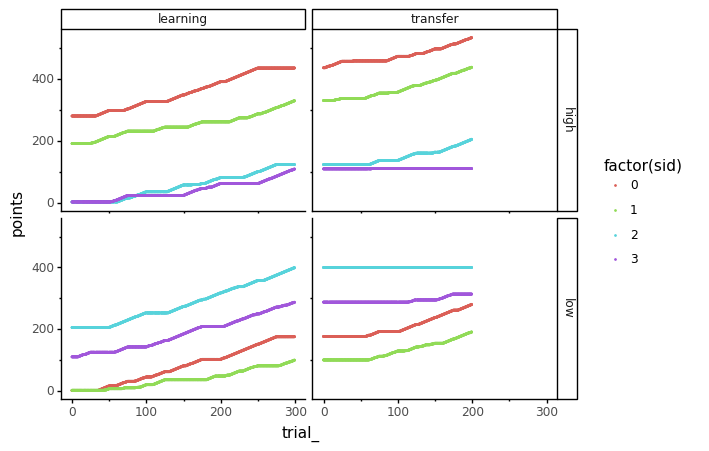

<ggplot: (-9223371914249289819)>

In [33]:
def plot_PointsOverTrials(dat, suf=''):
    
    g = (gg.ggplot(dat, gg.aes('trial_', 'points', color='factor(sid)'))
         + gg.geom_point(size=0.1)
         + gg.facet_grid('phase ~ trial_type')
        )
    g.save(os.path.join(plot_dir, '0_PointsOverTrials{}.png'.format(suf)))
    
    return g

# Use
plot_PointsOverTrials(all_data, '_all')
plot_PointsOverTrials(all_data.loc[np.invert(all_data['chance_performer'])])

## Response times

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\1_RTOverSubtrial_Details_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 107 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\1_RTOverSubtrial_Detail

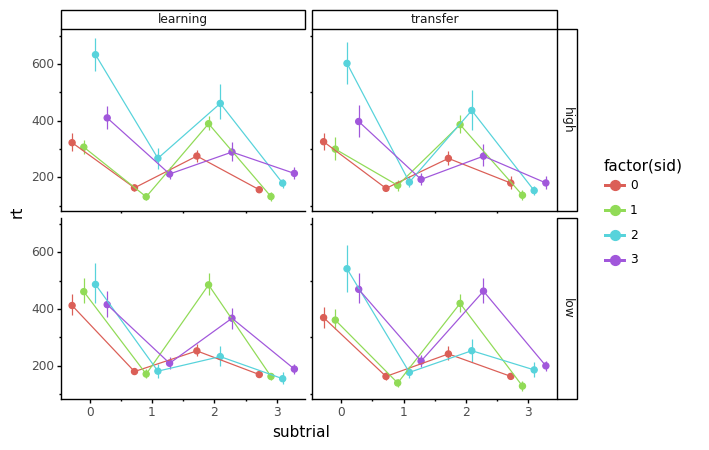

<ggplot: (-9223371914247805373)>

In [34]:
def plot_RTOverSubtrialDetails(dat, suf=''):
    
    g = (gg.ggplot(dat, gg.aes('subtrial', 'rt', color='factor(sid)', group='sid'))
         + gg.stat_summary(position=gg.position_dodge(width=0.75))
         + gg.stat_summary(position=gg.position_dodge(width=0.75), geom='line')
    #      + gg.stat_summary(gg.aes(group=1), color='black')
    #      + gg.stat_summary(gg.aes(group=1), geom='line', color='black')
         + gg.facet_grid('phase ~ trial_type')
        )
    g.save(os.path.join(plot_dir, '1_RTOverSubtrial_Details{}.png'.format(suf)))
    
    return g

# Use
plot_RTOverSubtrialDetails(all_data, '_all')
plot_RTOverSubtrialDetails(all_data.loc[np.invert(all_data['chance_performer'])])

## Learning curves

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\2_LearnCurves_Trial_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 11826 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\2_LearnCurves_Trial.png
  

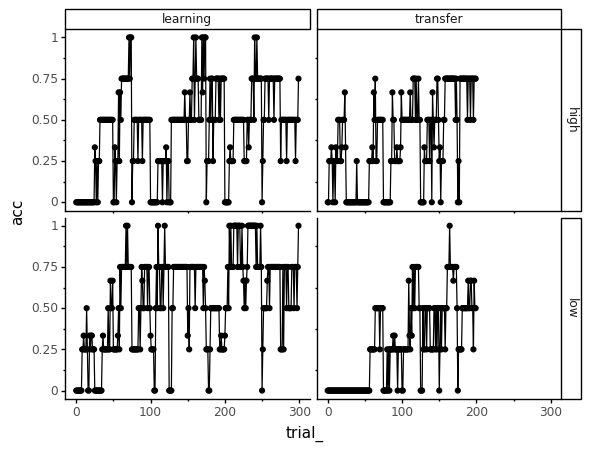

<ggplot: (-9223371914254258958)>

In [35]:
# Learning curves, averaging over goal stars 
def plot_LearnCurves_Trial(dat, suf=''):
    
    g = (gg.ggplot(dat, gg.aes('trial_', 'acc'))
         + gg.stat_summary(fun_y=np.mean, geom='point')
         + gg.stat_summary(fun_y=np.mean, geom='line')
     #     + gg.stat_summary()
     #     + gg.stat_summary(geom='line')
         + gg.facet_grid('phase ~ trial_type')
        )
    g.save(os.path.join(plot_dir, '2_LearnCurves_Trial{}.png'.format(suf)))
    
    return g

# Use
learn_curves_all = plot_LearnCurves_Trial(all_data, '_all')
learn_curves = plot_LearnCurves_Trial(all_data.loc[np.invert(all_data['chance_performer'])])
learn_curves

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\2_LearnCurves_Block.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 11826 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 11826 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


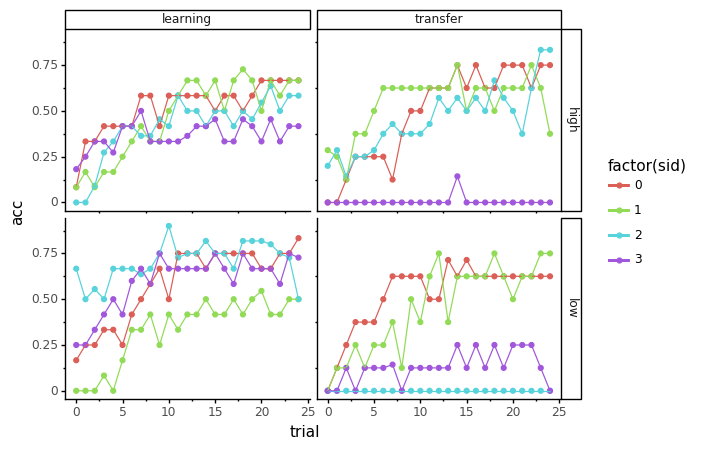

<ggplot: (-9223371914249538630)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\2_LearnCurves_Block_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 11826 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


In [36]:
# Learning curves, trial-by-trial
learn_curves2 = learn_curves + gg.aes(x='trial', color='factor(sid)')
learn_curves2.save(os.path.join(plot_dir, '2_LearnCurves_Block.png'))
print(learn_curves2)

learn_curves_all2 = learn_curves_all + gg.aes(x='trial', color='factor(sid)')
learn_curves_all2.save(os.path.join(plot_dir, '2_LearnCurves_Block_all.png'))

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\2_LearnCurves_Star.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 11826 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 11826 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


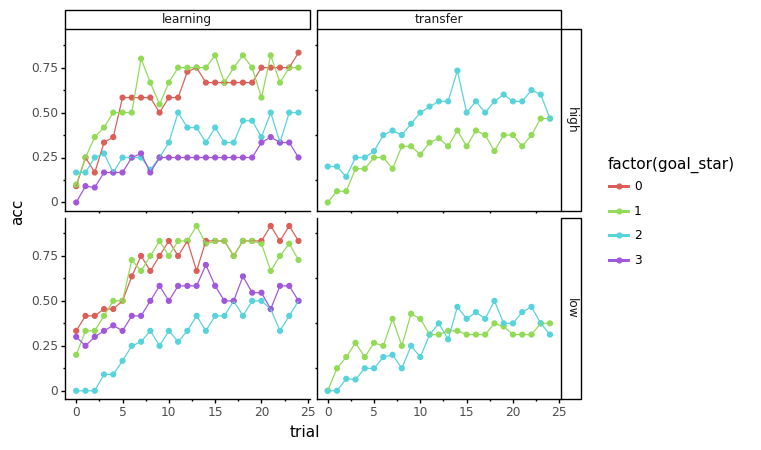

<ggplot: (-9223371914253869382)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\2_LearnCurves_Star_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 11826 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


In [37]:
# Learning curves, trial-by-trial
learn_curves3 = learn_curves + gg.aes(x='trial', color='factor(goal_star)')
learn_curves3.save(os.path.join(plot_dir, '2_LearnCurves_Star.png'))
print(learn_curves3)

learn_curves_all3 = learn_curves_all + gg.aes(x='trial', color='factor(goal_star)')
learn_curves_all3.save(os.path.join(plot_dir, '2_LearnCurves_Star_all.png'))

## Performance by star

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\3_PerformanceByStar_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\3_PerformanceByStar.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


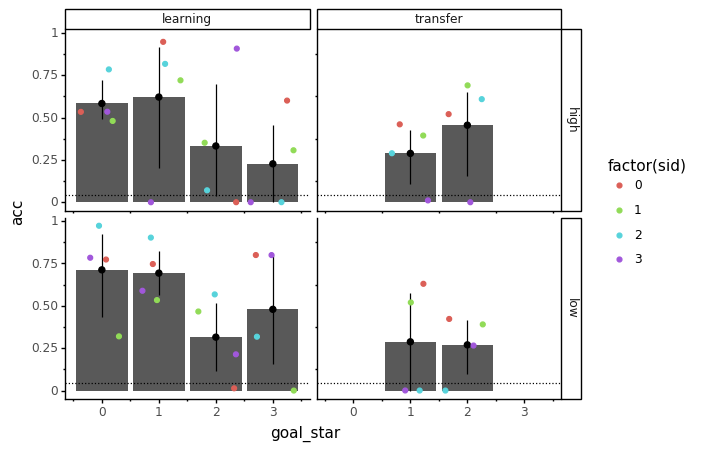

<ggplot: (122605514735)>

In [38]:
def plot_PerformanceByStar(dat, suf=''):
    
    id_cols = ['sid', 'phase', 'trial_type', 'goal_star']
    sum_dat = dat.groupby(id_cols).mean().reset_index()[id_cols + ['acc']]
    
    chance_perf = 1 / (4 * 3 * 2)
    g = (gg.ggplot(sum_dat, gg.aes('goal_star', 'acc'))
         + gg.stat_summary(geom='bar')
         + gg.stat_summary()
         + gg.geom_hline(yintercept=chance_perf, linetype='dotted')
         + gg.geom_point(gg.aes(color='factor(sid)'), position='jitter')
         + gg.facet_grid('phase ~ trial_type')
        )
    g.save(os.path.join(plot_dir, '3_PerformanceByStar{}.png'.format(suf)))
    
    return g

# Use
plot_PerformanceByStar(all_data, '_all')
plot_PerformanceByStar(all_data.loc[np.invert(all_data['chance_performer'])])

## Collecting the wrong star

In [39]:
def plot_CollectingWrongStar(dat, suf=''):
    
    # Get data
    id_cols = ['sid', 'phase', 'trial_type', 'unlocked_star']
    sub_dat = dat.loc[dat.correct == 0].reset_index()
    sum_dat = sub_dat.groupby(id_cols).count().reset_index()[id_cols + ['index']]
    sum_dat = sum_dat.rename(columns={'index': 'n_unlocked'})
    sum_dat.loc[np.isnan(sum_dat.n_unlocked), 'n_unlocked'] = 0
    
    # Plot
    g = (gg.ggplot(sum_dat, gg.aes('unlocked_star', 'n_unlocked'))
         + gg.stat_summary(geom='bar')
         + gg.stat_summary()
         + gg.geom_point(gg.aes(color='factor(sid)'), position='jitter')
         + gg.facet_grid('phase ~ trial_type')
        )
    g.save(os.path.join(plot_dir, '4_CollectingWrongStar{}.png'.format(suf)))

# Use
plot_CollectingWrongStar(all_data, '_all')
plot_CollectingWrongStar(all_data.loc[np.invert(all_data['chance_performer'])])

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\4_CollectingWrongStar_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\4_CollectingWrongStar.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


## Perseverance: Following old rules after transfer

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\5_PerseveranceLowRules_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\5_PerseveranceLowRules.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


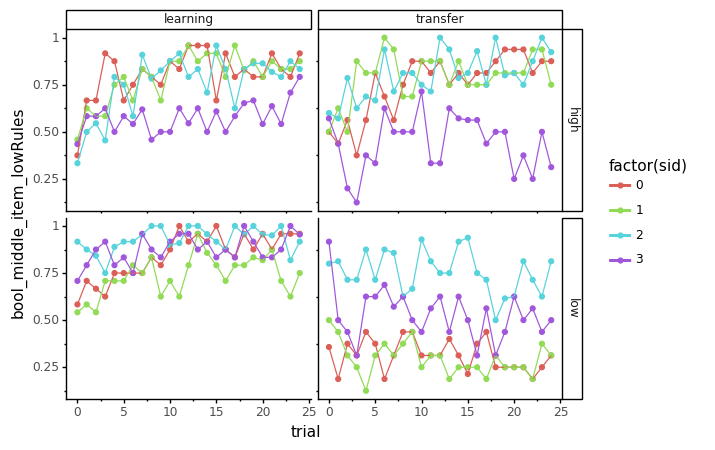

<ggplot: (122606512248)>

In [53]:
# How often do participants apply the low rules of the learning phase?
# -> Perseveration if they do it during low transfer (low rules don't work any more)!
# -> Confusion if they stop doing it during high transfer (low rules still work)!

def plot_PerseveraceLowRules(dat, suf=''):
    
    g = (gg.ggplot(dat, gg.aes('trial', 'bool_middle_item_lowRules', color='factor(sid)'))
         + gg.stat_summary(fun_y=np.mean, geom='point')
         + gg.stat_summary(fun_y=np.mean, geom='line')
         + gg.facet_grid('phase ~ trial_type')
        )
    g.save(os.path.join(plot_dir, '5_PerseveranceLowRules{}.png'.format(suf)))
    
    return g

# Use
sub_dat = all_data.loc[all_data.subtrial.isin([1, 3])]
pers_all = plot_PerseveraceLowRules(sub_dat, '_all')
pers = plot_PerseveraceLowRules(sub_dat.loc[np.invert(sub_dat['chance_performer'])])
pers

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\5_PerseveranceHighRules_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\5_PerseveranceHighRules.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


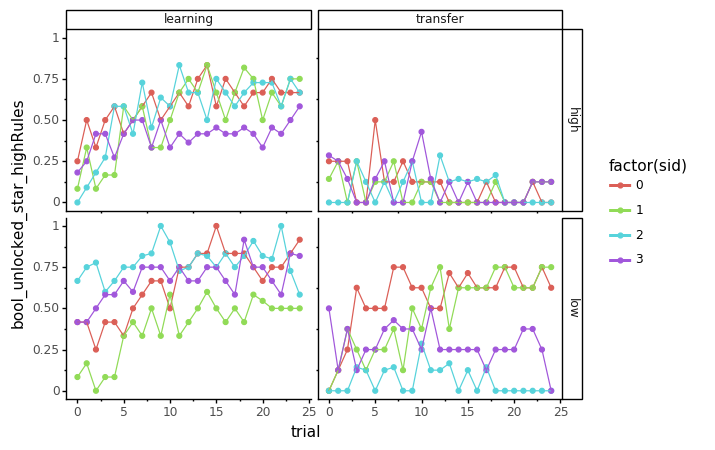

<ggplot: (-9223371914249167458)>


In [55]:
# How often do participants apply the high rules of the learning phase?
# -> Perseveration if they do it during high transfer (high rules don't work any more)!
# -> Relearning of middle-layer items if they increase during low transfer (same high rules, different low rules)!

pers_all2 = pers_all + gg.aes(y='bool_unlocked_star_highRules')
pers_all2.data = pers_all.data.loc[pers_all.data.subtrial == 3]
pers_all2.save(os.path.join(plot_dir, '5_PerseveranceHighRules_all.png'))

pers2 = pers + gg.aes(y='bool_unlocked_star_highRules')
pers2.data = pers.data.loc[pers.data.subtrial == 3]
pers2.save(os.path.join(plot_dir, '5_PerseveranceHighRules.png'))
print(pers2)

## Analyzing performance by level

In [ ]:
# More details analysis of performance for low-level rules
# No decline in high transfer phase -> low rules didn't change
# Decline and relearning in low transfer phase -> low rules changed
pers_all3 = pers_all + gg.aes(y='bool_middle_item_lowTransferRules')
pers_all3.save(os.path.join(plot_dir, '6_DetailsLowTransferRules_all.png'))

pers3 = pers + gg.aes(y='bool_middle_item_lowTransferRules')
pers3.save(os.path.join(plot_dir, '6_DetailsLowTransferRules.png'))
pers3

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\6_DetailsLowTransferRules_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\6_DetailsLowTransferRules.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\6_DetailsHighTransferRules_all.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\6_DetailsHighTransferRules.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


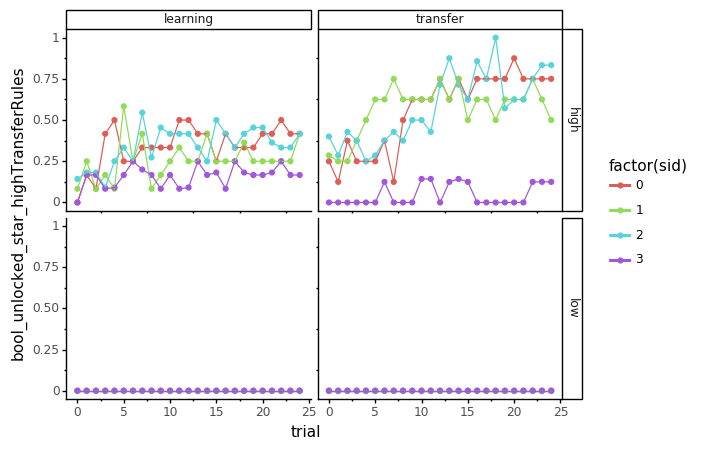

<ggplot: (122600980835)>

In [57]:
# More details analysis of performance for high-level rules
# Decline and relearning in high transfer phase -> high rules changed
# Decline and relearning in low transfer phase -> high rules are the same, but low-level components changed
pers_all4 = pers_all2 + gg.aes(y='bool_unlocked_star_highTransferRules')
pers_all4.save(os.path.join(plot_dir, '6_DetailsHighTransferRules_all.png'))

pers4 = pers2 + gg.aes(y='bool_unlocked_star_highTransferRules')
pers4.save(os.path.join(plot_dir, '6_DetailsHighTransferRules.png'))
pers4

## Time frame for learning low / high rules

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\7_TimeFrameLearnRulesLow_all
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\7_TimeFrameLearnRulesLow
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), unit

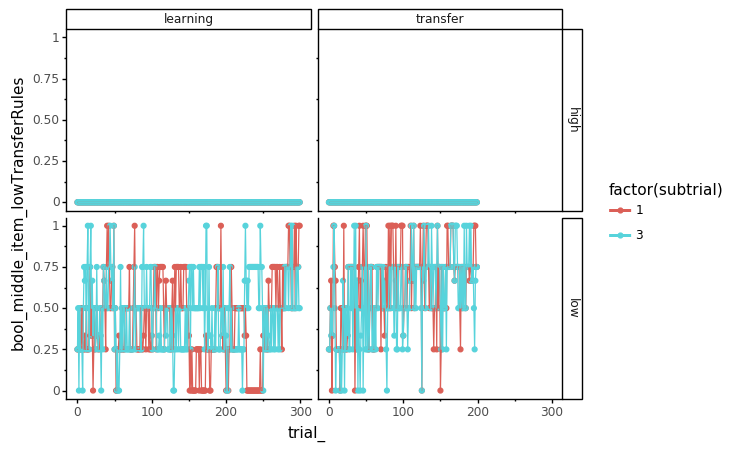

<ggplot: (122602302668)>

In [46]:
# How fast are low rules learnt? How many middle-items are produced through learning?
def plot_TimeframeLearnRules(dat, suf):
    
    # Get data
    if 'Low' in suf:
        sub_dat = dat.loc[dat['subtrial'].isin([1, 3])]  # Select subtrials 1 and 3, in which middle-items *can* appear
        y = 'bool_middle_item_lowRules'
        if 'Trans' in suf:
            y = 'bool_middle_item_lowTransferRules'

    elif 'High' in suf:
        sub_dat = all_data.loc[all_data['subtrial'] == 3]  # Select subtrial 3, in which stars *can* appear
        y = 'bool_unlocked_star_highRules'
        if 'Trans' in suf:
            y = 'bool_unlocked_star_highTransferRules'
    else:
        raise(ValueError, 'suf must contain either "Low", or "High".')

    # Plot
    g = (gg.ggplot(sub_dat, gg.aes('trial_', y, color='factor(subtrial)'))
         + gg.stat_summary(fun_y=np.mean, geom='point')
         + gg.stat_summary(fun_y=np.mean, geom='line')
         + gg.facet_grid('phase ~ trial_type')
        )
    g.save(os.path.join(plot_dir, '7_TimeFrameLearnRules{}'.format(suf)))
    
    return g

# Use
plot_TimeframeLearnRules(all_data, 'Low_all')
plot_TimeframeLearnRules(all_data.loc[np.invert(all_data['chance_performer'])], 'Low')
plot_TimeframeLearnRules(all_data, 'LowTrans_all')
plot_TimeframeLearnRules(all_data.loc[np.invert(all_data['chance_performer'])], 'LowTrans')

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\7_TimeFrameLearnRulesHigh_all
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/RPPfigures\7_TimeFrameLearnRulesHigh
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), un

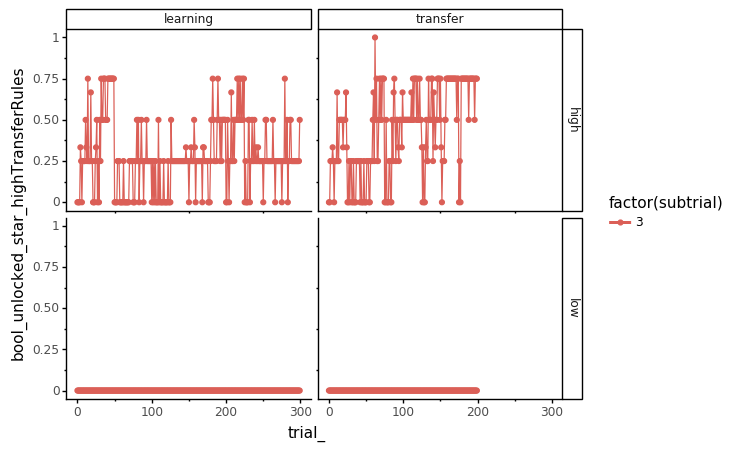

<ggplot: (-9223371914253614876)>

In [47]:
plot_TimeframeLearnRules(all_data, 'High_all')
plot_TimeframeLearnRules(all_data.loc[np.invert(all_data['chance_performer'])], 'High')
plot_TimeframeLearnRules(all_data, 'HighTrans_all')
plot_TimeframeLearnRules(all_data.loc[np.invert(all_data['chance_performer'])], 'HighTrans')